# Problem Statement

- In a world of uncountable entertainment options, it gets perperlxing for the consumer to decide and choose what is best for them
- Understanding that the importance of choosing a relevant product to a customer's mood and emotions

# Structure of Project

1. Data and Libraries Load
2. Data Exploratory
3. Data Preprocessing
    - Classic Data Augmentation (Rotation/Flipping/Brightness)
4. Running Baseline Models
    - CNN 
    - Transfer Learning
        - VGG16
        - ResNet50
5. Improving Selected Model Performance
    - L2 Regularization
    - More Data Augmentation using Mixup
    - Dropout
    - Optuna
6. Saving Best Model

# 1. Data and Libraries Load

## Libraries

In [1]:
import math
import numpy as np
from numpy import expand_dims

import pandas as pd
import itertools

from datetime import datetime

import scikitplot
import seaborn as sns
import os

from PIL import Image, ImageFont

from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.image import imread

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input

from keras.preprocessing.image import img_to_array

## Data

Our dataset has 2 files
- Training: Used as Training Data
- Public Test: Used as Testing data

In each dataset file, there are 7 emotions:
1. Disgust
2. Angry
3. Neutral
4. Happy
5. Fear
6. Sad
7. Surprise

### Creating Paths to Images
*note that we will only be using "Training" and "PublicTest" datasets*

In [2]:
os.listdir('../input/fer2013clean')
os.listdir('../input/fer2013clean/fer2013-clean/Training/')
os.listdir('../input/fer2013clean/fer2013-clean/PublicTest/')
train_dir = '../input/fer2013clean/fer2013-clean/Training/'
test_dir = '../input/fer2013clean/fer2013-clean/PublicTest/'

# 2. Data Exploratory

The images are of all varying qualities (different age groups, different ethnicities, some with hands some not, and some with very dark saturated contrast)

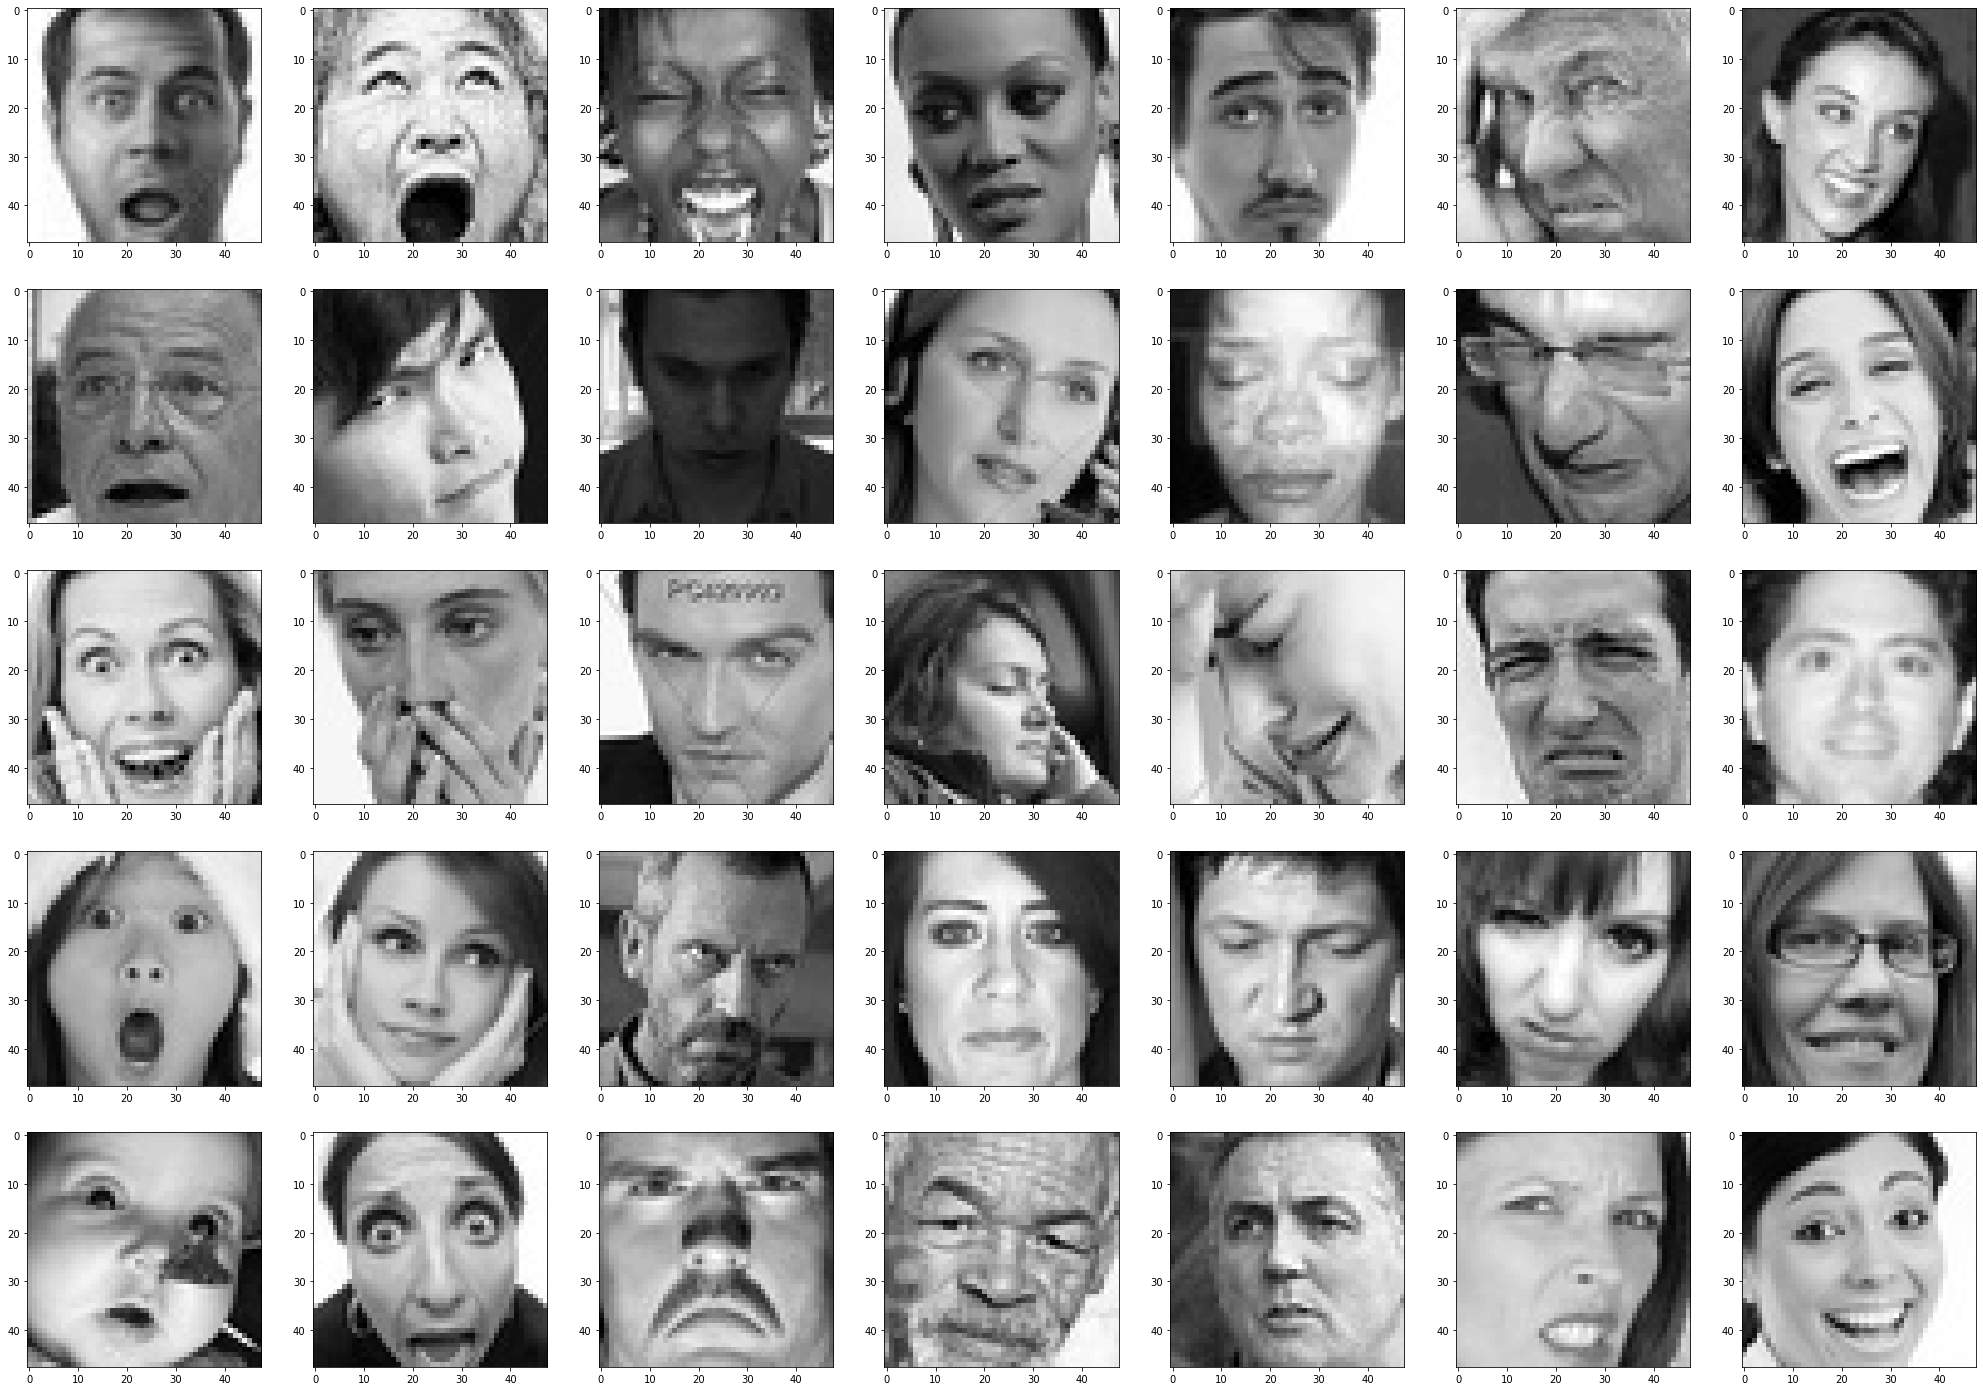

In [3]:
train_total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=train_total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(train_total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

## Number of Images/Emotions in Train Set

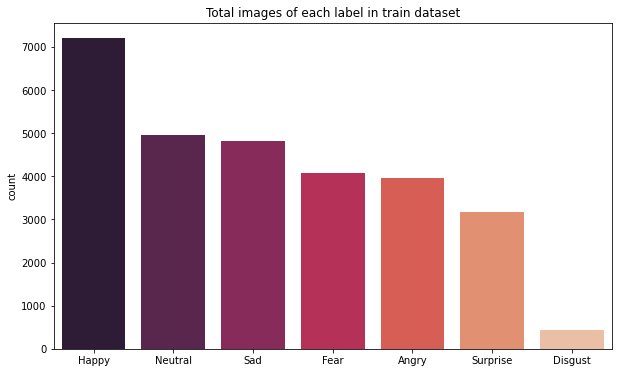

In [4]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="rocket", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

In [5]:
for expression in os.listdir(train_dir):
    print(str(len(os.listdir(train_dir + expression))) + " " + expression + " images")

3163 Surprise images
4066 Fear images
3961 Angry images
4952 Neutral images
4825 Sad images
434 Disgust images
7203 Happy images


## Image per emotion (Train)

Writing a function to display emotion

In [6]:
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

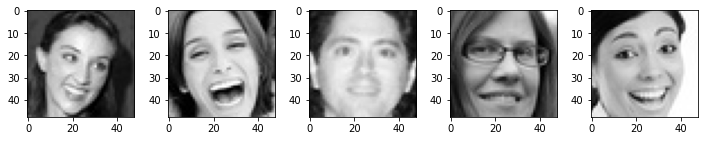

In [7]:
plot_imgs(train_dir+'Happy')

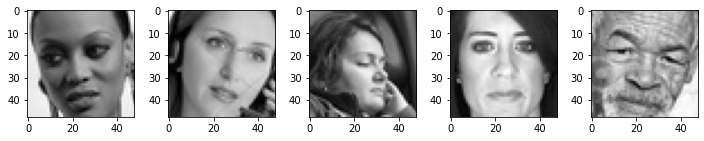

In [8]:
plot_imgs(train_dir+'Neutral')

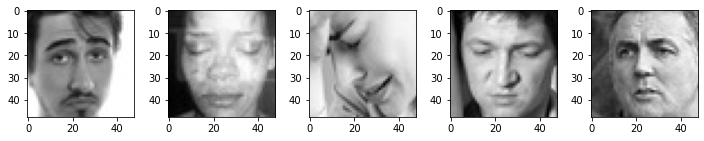

In [9]:
plot_imgs(train_dir+'Sad')

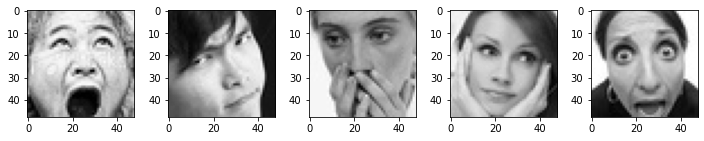

In [10]:
plot_imgs(train_dir+'Fear')

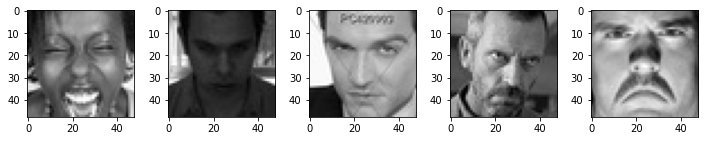

In [11]:
plot_imgs(train_dir+'Angry')

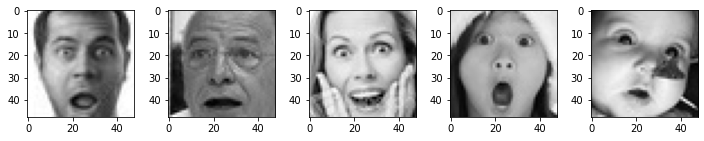

In [12]:
plot_imgs(train_dir+'Surprise')

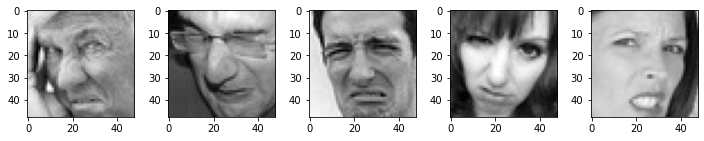

In [13]:
plot_imgs(train_dir+'Disgust')

## Number of Images/Emotions in Test Set

- Similar to the other datasets, image quality is varied, with different crop degrees to the face,difference in contrast
- Within this example, there are also more noticeable words (trademark) across the face that might influence learning/ other random noises like paint smeared over the face

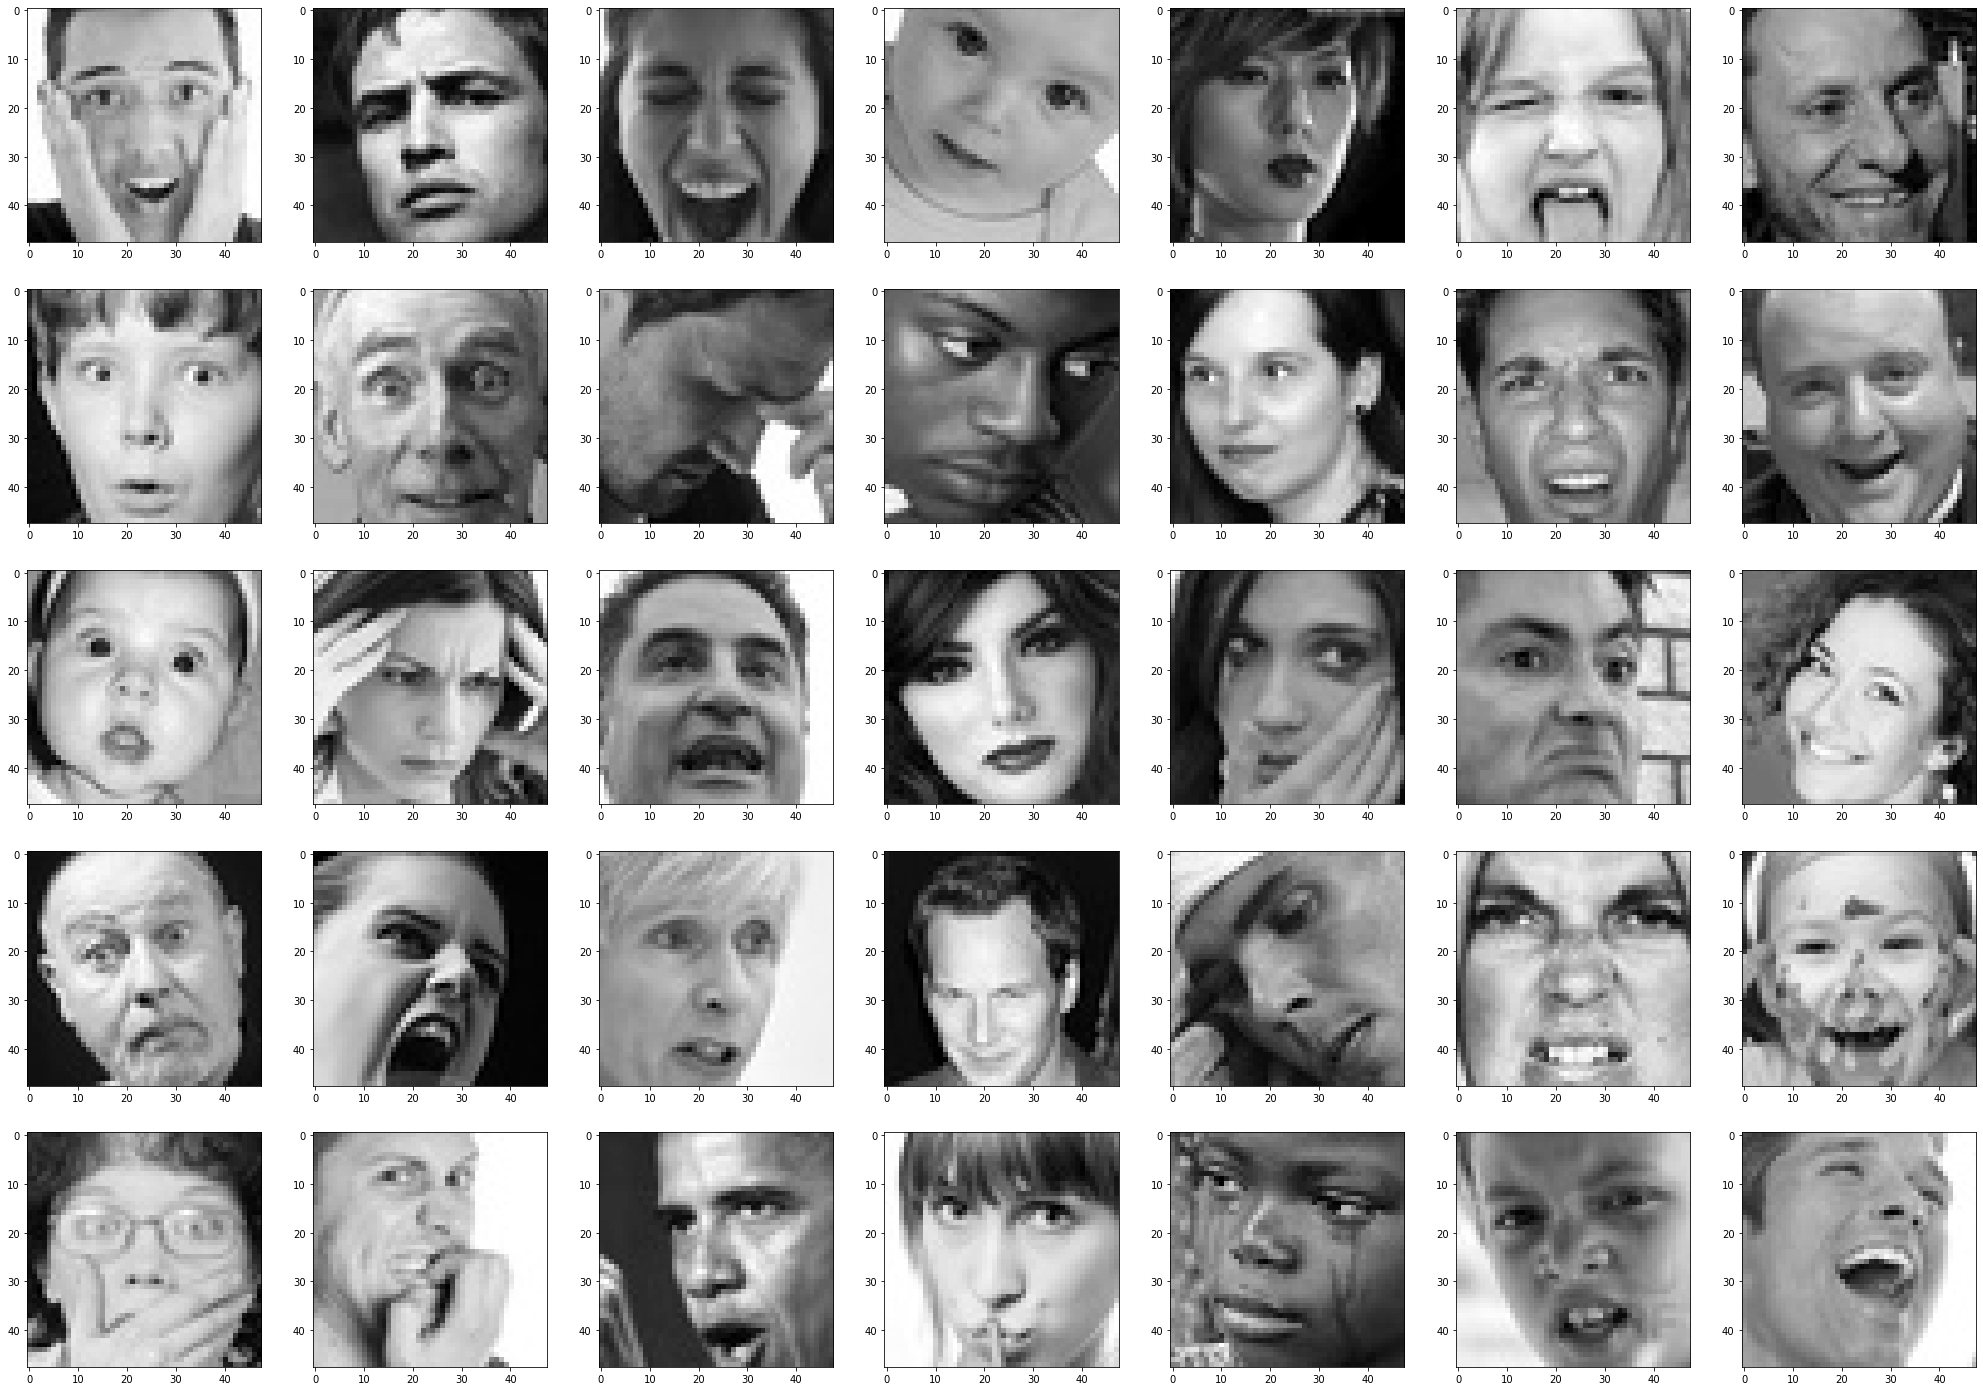

In [14]:
test_total_labels = len(os.listdir(test_dir))

fig, ax = plt.subplots(nrows=5, ncols=test_total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(test_total_labels),os.listdir(test_dir)):
        ax[x][y].imshow(imread(test_dir+v+'/'+os.listdir(test_dir+v)[x]), cmap='gray')

plt.show()

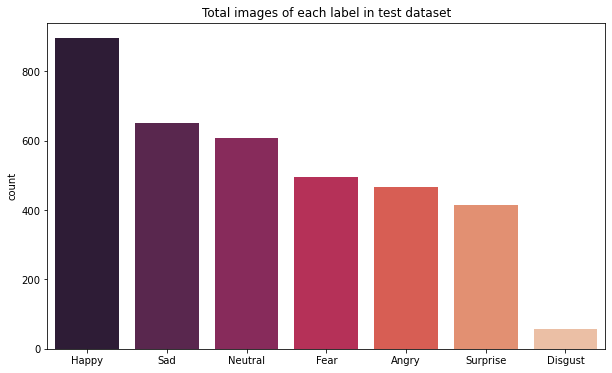

In [15]:
df = {}
for i in os.listdir(test_dir):
    directory = test_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="rocket", data=df)
plt.ylabel("count")
plt.title("Total images of each label in test dataset")
plt.show()

In [16]:
for expression in os.listdir(test_dir):
    print(str(len(os.listdir(test_dir + expression))) + " " + expression + " images")


415 Surprise images
496 Fear images
465 Angry images
607 Neutral images
652 Sad images
56 Disgust images
895 Happy images


## Image per emotion (Test)

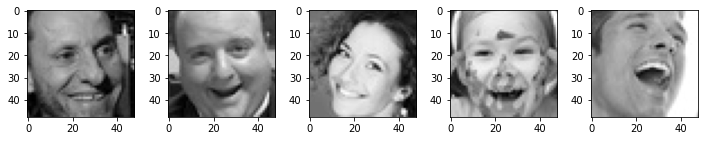

In [17]:
plot_imgs(test_dir+'Happy')

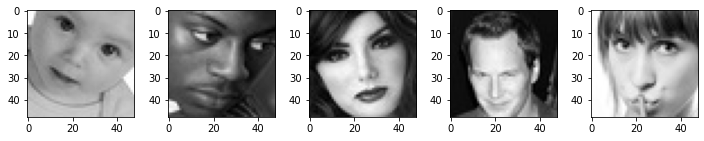

In [18]:
plot_imgs(test_dir+'Neutral')

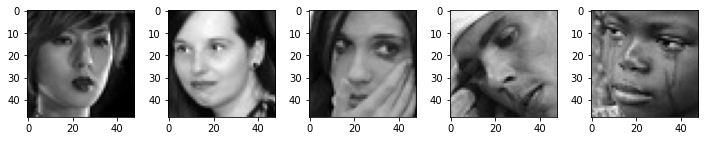

In [19]:
plot_imgs(test_dir+'Sad')

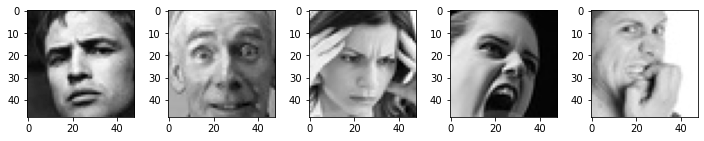

In [20]:
plot_imgs(test_dir+'Fear')

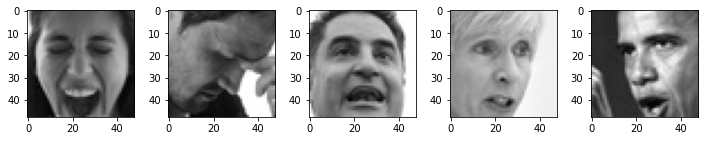

In [21]:
plot_imgs(test_dir+'Angry')

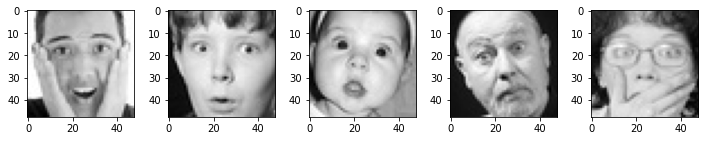

In [22]:
plot_imgs(test_dir+'Surprise')

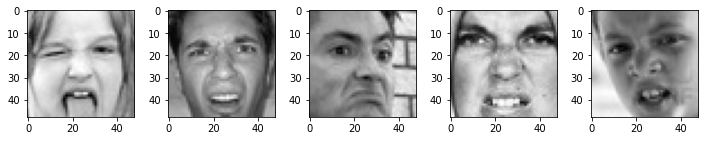

In [23]:
plot_imgs(test_dir+'Disgust')

# 3. Data Preprocessing

We will be doing data augmentation and rescaling on the datasets as part of our preprocessing.

Data augmentation will be done on the training set only to expand it and improve the performance and ability of hte model to generalize. Some of the basic data augmentation techniques will be:

Flipping: flipping the image horizontally
Rotation: rotates the image by a specified range
Changing brightness or contrast: some images are particularly dark and bright
Other popular augmentation techniques will not be chosen due to the following reasons specific to our dataset scenario

Zoom in, Zoom out: Our images are cropped neatly to focus on the face as the image's center
Shearing: Faces in images are not skewed

## Visualizing augmentation on 1 image

Loading one image

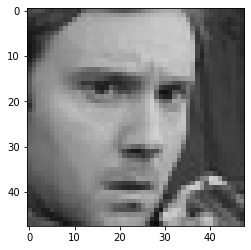

In [24]:
# load the image
img = load_img('../input/angrytest/0.jpg')
#display image
imgplot = plt.imshow(img)
plt.show()

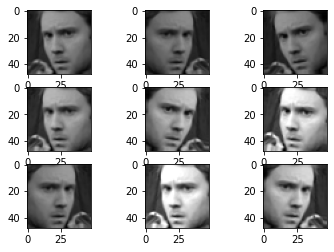

In [25]:
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=10,
                             horizontal_flip = True,
                             brightness_range = [0.5,1.2])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

## Finalizing Data Augmentation Feaures

In [26]:
# Generates new images from existing ones 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                   rotation_range = 10,
                                   brightness_range = [0.5,1.2]) #values lower than 1 darken the images
test_datagen  = ImageDataGenerator(rescale=1./255)

## Creating Train/Test Generators

For Grayscale

In [27]:
train_generator = train_datagen.flow_from_directory(
                                train_dir,
                                target_size=(48,48),
                                batch_size=64,
                                color_mode='grayscale',
                                class_mode='categorical')

# New test images
test_generator = test_datagen.flow_from_directory(
                                test_dir,
                                target_size=(48,48),
                                batch_size=1,
                                color_mode='grayscale',
                                class_mode='categorical',
                                shuffle=False)

Found 28604 images belonging to 7 classes.
Found 3586 images belonging to 7 classes.


In [28]:
train_generator.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [29]:
test_generator.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

For RBG

In [30]:
train_generator_2 = train_datagen.flow_from_directory(
                                train_dir,
                                target_size=(48,48),
                                batch_size=64,
                                color_mode='rgb',
                                class_mode='categorical')

test_generator_2 = test_datagen.flow_from_directory(
                                test_dir,
                                target_size=(48,48),
                                batch_size=1,
                                color_mode='rgb',
                                class_mode='categorical',
                                shuffle=False)

Found 28604 images belonging to 7 classes.
Found 3586 images belonging to 7 classes.


# 4. Running Baseline Models

For selection of best model, my approach will be to run 3 models at its basic/default settings so then to narrow down to the best performing model.

Thereafter, I will work to improve the score of the selected model.

Models I will be testing are:
* A: Self-build CNN
* B: VGGFace Transfer Learning
* C: VGG16 Transfer Learning 
* D: ResNet Transfer Learning

Default Hyper-params for Models

In [31]:
num_classes = 7
dropout_rate = 0.25
num_epochs = 65
lr = 0.0001

In [32]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_test =test_generator.n//test_generator.batch_size

## Model A: CNN

Model Build

In [33]:
model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

# summary layers
model.summary()

# Compile Model
opt = optimizers.Adam(lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

checkpoint_cnn = ModelCheckpoint("cnn_model.h5", 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)

callbacks_list_cnn = [checkpoint_cnn]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

Model Train

In [34]:
history = model.fit_generator(train_generator, 
                    steps_per_epoch=step_size_train, 
                    epochs=num_epochs,  
                    verbose=1,
                    validation_data=test_generator,  
                    validation_steps=step_size_test,
                    callbacks=callbacks_list_cnn) 

Epoch 1/65
446/446 [==============================] - ETA: 0s - loss: 2.0107 - accuracy: 0.2223
Epoch 00001: val_loss improved from inf to 1.82422, saving model to cnn_model.h5
446/446 [==============================] - 275s 616ms/step - loss: 2.0107 - accuracy: 0.2223 - val_loss: 1.8242 - val_accuracy: 0.2499
Epoch 2/65
446/446 [==============================] - ETA: 0s - loss: 1.8506 - accuracy: 0.2768
Epoch 00002: val_loss improved from 1.82422 to 1.64508, saving model to cnn_model.h5
446/446 [==============================] - 73s 163ms/step - loss: 1.8506 - accuracy: 0.2768 - val_loss: 1.6451 - val_accuracy: 0.3458
Epoch 3/65
446/446 [==============================] - ETA: 0s - loss: 1.7407 - accuracy: 0.3239
Epoch 00003: val_loss did not improve from 1.64508
446/446 [==============================] - 72s 161ms/step - loss: 1.7407 - accuracy: 0.3239 - val_loss: 1.6641 - val_accuracy: 0.3589
Epoch 4/65
446/446 [==============================] - ETA: 0s - loss: 1.6623 - accuracy: 0.3

Evaluating Model Performance

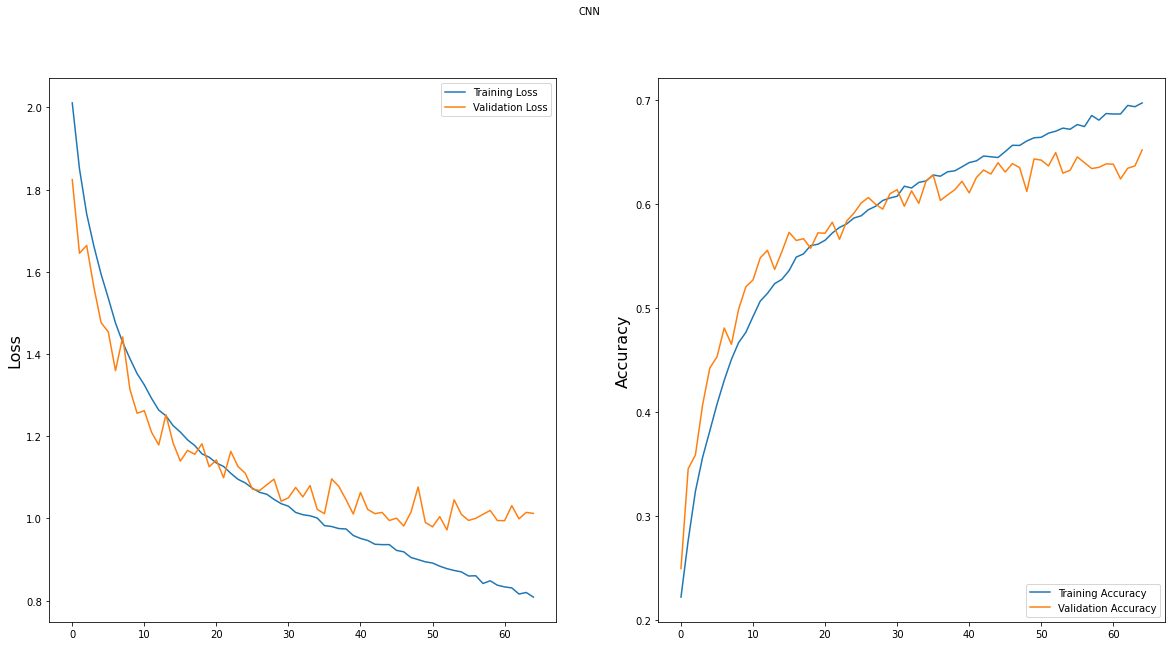

3586/3586 [==============================] - 11s 3ms/step - loss: 1.0123 - accuracy: 0.6523
Test Loss: 1.0122674703598022
Test Accuracy: 0.6522588133811951


In [35]:
# visualizing losses and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('CNN', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

result = model.evaluate(test_generator, steps=step_size_test) 
print("Test Loss: " + str(result[0]))
print("Test Accuracy: " + str(result[1]))

Predictions

In [36]:
predictions = model.predict_generator(generator=test_generator)
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

Confusion Matrix

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[235  14  32  47  83  47   7]
 [ 10  34   0   3   4   4   1]
 [ 37   6 169  40  91 110  43]
 [  7   0   4 816  52   6  10]
 [ 22   1  18  68 435  58   5]
 [ 41   8  30  69 159 336   9]
 [ 10   3  24  28  24  12 314]]


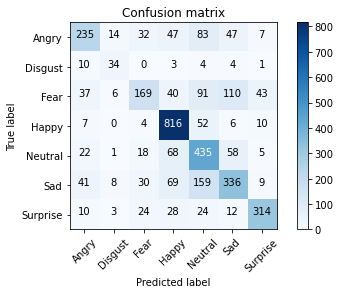

In [38]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show();

Classification Report

In [39]:
print('Classification Report')
target_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral','Sad', 'Surprise']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Angry       0.65      0.51      0.57       465
     Disgust       0.52      0.61      0.56        56
        Fear       0.61      0.34      0.44       496
       Happy       0.76      0.91      0.83       895
     Neutral       0.51      0.72      0.60       607
         Sad       0.59      0.52      0.55       652
    Surprise       0.81      0.76      0.78       415

    accuracy                           0.65      3586
   macro avg       0.63      0.62      0.62      3586
weighted avg       0.65      0.65      0.64      3586



In [40]:
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 65.2% 


Misclassified Images

In [41]:
text_to_label = {'Angry': 0,'Disgust': 1,'Fear': 2,'Happy': 3,'Neutral': 4,'Sad': 5,'Surprise': 6}

In [42]:
label_to_text= {0: 'Angry',1: 'Disgust',2: 'Fear', 3: 'Happy', 4: 'Neutral',5: 'Sad',6: 'Surprise'}

In [43]:
# for i, (img, label) in enumerate(test_generator): # [B, H, W, C] 
#     pred = y_pred[i]    #shuffle should be false
    
#     img = img[0] # [H, W, C]
#     label = np.argmax(label[0])
#     print(f"Pred = {label_to_text[pred]} | Label = {label_to_text[label]}")
#     if pred != label:
#         plt.imshow(img)
#         break

## Model B: VGGFace2 Transfer Learning

Downloading packages

In [44]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-659c52rg
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8310 sha256=89d02ce6144274d25c2a818685449d403c55028c2cc8bee5eab4f1ddae6bda29
  Stored in directory: /tmp/pip-ephem-wheel-cache-g4l6xv0e/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 50 kB 746 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Model Build

In [45]:
VGGFace().summary()

580075520/580070376 [==============================] - 14s 0us/step
Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
___________________________________________________

In [46]:
vggface = VGGFace(include_top=False, 
                  input_shape=(48, 48, 3))
last_layer = vggface.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(512, activation='relu', name='fc6')(x)
x = Dense(512, activation='relu', name='fc7')(x)
out = Dense(7, activation='softmax', name='fc8')(x)
model_vggface = Model(vggface.input, out)
model_vggface.summary()

58916864/58909280 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 24, 24, 128)       147584    
_______________________________________________________

In [47]:
layers = [(layer, layer.name, layer.trainable) for layer in model_vggface.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])       

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_2,True
1,<tensorflow.python.keras.layers.convolutional....,conv1_1,True
2,<tensorflow.python.keras.layers.convolutional....,conv1_2,True
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,pool1,True
4,<tensorflow.python.keras.layers.convolutional....,conv2_1,True
5,<tensorflow.python.keras.layers.convolutional....,conv2_2,True
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,pool2,True
7,<tensorflow.python.keras.layers.convolutional....,conv3_1,True
8,<tensorflow.python.keras.layers.convolutional....,conv3_2,True
9,<tensorflow.python.keras.layers.convolutional....,conv3_3,True


In [48]:
model_vggface.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr),
              metrics=['accuracy'])

In [49]:
checkpoint_vggface = ModelCheckpoint(filepath='model_vggface.h5',
                                     verbose=1,
                                     save_best_only=True)

callbacks_list_vggface = [checkpoint_vggface]

In [50]:
history = model_vggface.fit_generator(train_generator_2,
                                      steps_per_epoch=step_size_train,
                                      epochs = num_epochs, 
                                      verbose=1,
                                      validation_data = test_generator_2, 
                                      validation_steps = step_size_test,
                                      callbacks=callbacks_list_vggface)

Epoch 1/65
446/446 [==============================] - ETA: 0s - loss: 1.4662 - accuracy: 0.4385
Epoch 00001: val_loss improved from inf to 1.27979, saving model to model_vggface.h5
446/446 [==============================] - 72s 161ms/step - loss: 1.4662 - accuracy: 0.4385 - val_loss: 1.2798 - val_accuracy: 0.5159
Epoch 2/65
446/446 [==============================] - ETA: 0s - loss: 1.2485 - accuracy: 0.5317
Epoch 00002: val_loss improved from 1.27979 to 1.17943, saving model to model_vggface.h5
446/446 [==============================] - 83s 187ms/step - loss: 1.2485 - accuracy: 0.5317 - val_loss: 1.1794 - val_accuracy: 0.5530
Epoch 3/65
446/446 [==============================] - ETA: 0s - loss: 1.1502 - accuracy: 0.5681
Epoch 00003: val_loss improved from 1.17943 to 1.13207, saving model to model_vggface.h5
446/446 [==============================] - 73s 163ms/step - loss: 1.1502 - accuracy: 0.5681 - val_loss: 1.1321 - val_accuracy: 0.5753
Epoch 4/65
446/446 [===========================

Evaluating Model Performance

In [51]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


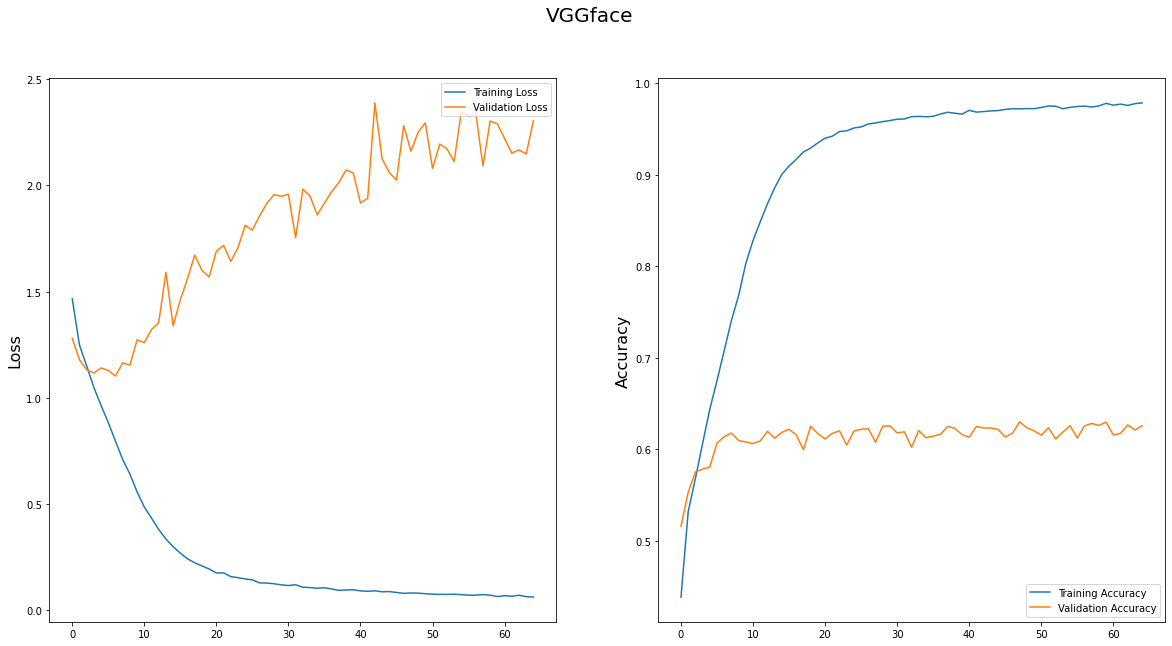

3586/3586 [==============================] - 16s 4ms/step - loss: 2.3040 - accuracy: 0.6258
Test Loss: 2.3040380477905273
Test Accuracy: 0.6257668733596802


In [52]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('VGGface', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Evaluate Model
result = model_vggface.evaluate(test_generator_2, steps=step_size_test) 
print("Test Loss: " + str(result[0]))
print("Test Accuracy: " + str(result[1]))

Predictions

In [53]:
predictions = model_vggface.predict_generator(generator=test_generator_2)
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator_2.classes
class_names = test_generator_2.class_indices.keys()

Confusion Matrix

Confusion matrix, without normalization
[[268   1  37  18  59  66  16]
 [ 12  30   3   1   4   6   0]
 [ 58   0 222  12  57 107  40]
 [ 32   2  23 725  62  34  17]
 [ 56   1  30  55 335 119  11]
 [ 87   1  50  40 129 330  15]
 [  9   0  26  15  16  15 334]]


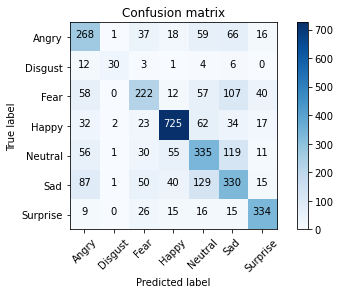

In [54]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

Classification Report

In [55]:
print('Classification Report')
print(classification_report(test_generator_2.classes, y_pred, target_names=target_names))
accuracy = accuracy_score(test_generator_2.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Classification Report
              precision    recall  f1-score   support

       Angry       0.51      0.58      0.54       465
     Disgust       0.86      0.54      0.66        56
        Fear       0.57      0.45      0.50       496
       Happy       0.84      0.81      0.82       895
     Neutral       0.51      0.55      0.53       607
         Sad       0.49      0.51      0.50       652
    Surprise       0.77      0.80      0.79       415

    accuracy                           0.63      3586
   macro avg       0.65      0.60      0.62      3586
weighted avg       0.63      0.63      0.63      3586

Accuracy in test set: 62.6% 


Misclassified Image

Pred = Neutral | Label = Angry


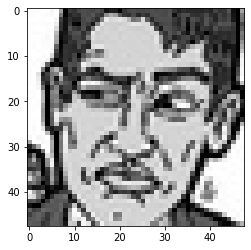

In [56]:
for i, (img, label) in enumerate(test_generator_2): # [B, H, W, C] 
    pred = y_pred[i]    #shuffle should be false
    
    img = img[0] # [H, W, C]
    label = np.argmax(label[0])
    print(f"Pred = {label_to_text[pred]} | Label = {label_to_text[label]}")
    if pred != label:
        plt.imshow(img)
        break

## Model C: VGG16 Transfer Learning

Model Build

In [57]:
vgg = VGG16(include_top=False, 
            input_shape=(48,48,3),
            weights = "imagenet",
            pooling='avg',
            #input_shape=None,
            classes=num_classes)

58892288/58889256 [==============================] - 1s 0us/step


In [58]:
"""
option 1
setting all layers trainable
"""

vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    set_trainable = True

In [59]:
# adding dense layers
x = vgg.output

# x = GlobalAveragePooling2D()(x) #Adaptive Pooling

# # let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# # and a logits layer -- let's say we have 2 classes
predictions = Dense(num_classes, activation='softmax')(x)

# # this is the model we will train
model_vgg = Model(inputs=vgg.input, outputs=predictions)


# x = Flatten()(vgg.output)
# prediction = Dense(num_classes, activation='softmax')(x)
# model_vgg = Model(inputs=vgg.input, outputs=prediction)
#model_vgg.summary()

In [60]:
layers = [(layer, layer.name, layer.trainable) for layer in model_vgg.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])       

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_3,True
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,True
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,True
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,True


In [61]:
model_vgg.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr),
                  metrics=['accuracy'])

In [62]:
checkpoint_vgg = ModelCheckpoint(filepath='model_vgg.h5',
                             verbose=1,
                             save_best_only=True)


callbacks_list_vgg = [checkpoint_vgg]

start = datetime.now()

history = model_vgg.fit_generator(train_generator_2,
                                  steps_per_epoch=step_size_train,
                                  epochs = num_epochs, 
                                  verbose=1,
                                  validation_data = test_generator_2, 
                                  validation_steps = step_size_test,
                                  callbacks=callbacks_list_vgg)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/65
446/446 [==============================] - ETA: 0s - loss: 1.4176 - accuracy: 0.4525
Epoch 00001: val_loss improved from inf to 1.17352, saving model to model_vgg.h5
446/446 [==============================] - 75s 168ms/step - loss: 1.4176 - accuracy: 0.4525 - val_loss: 1.1735 - val_accuracy: 0.5538
Epoch 2/65
446/446 [==============================] - ETA: 0s - loss: 1.1628 - accuracy: 0.5650
Epoch 00002: val_loss improved from 1.17352 to 1.09607, saving model to model_vgg.h5
446/446 [==============================] - 73s 163ms/step - loss: 1.1628 - accuracy: 0.5650 - val_loss: 1.0961 - val_accuracy: 0.5906
Epoch 3/65
446/446 [==============================] - ETA: 0s - loss: 1.0694 - accuracy: 0.6019
Epoch 00003: val_loss improved from 1.09607 to 1.05884, saving model to model_vgg.h5
446/446 [==============================] - 71s 160ms/step - loss: 1.0694 - accuracy: 0.6019 - val_loss: 1.0588 - val_accuracy: 0.6049
Epoch 4/65
446/446 [==============================] - ETA: 

Evaluating Model Performance

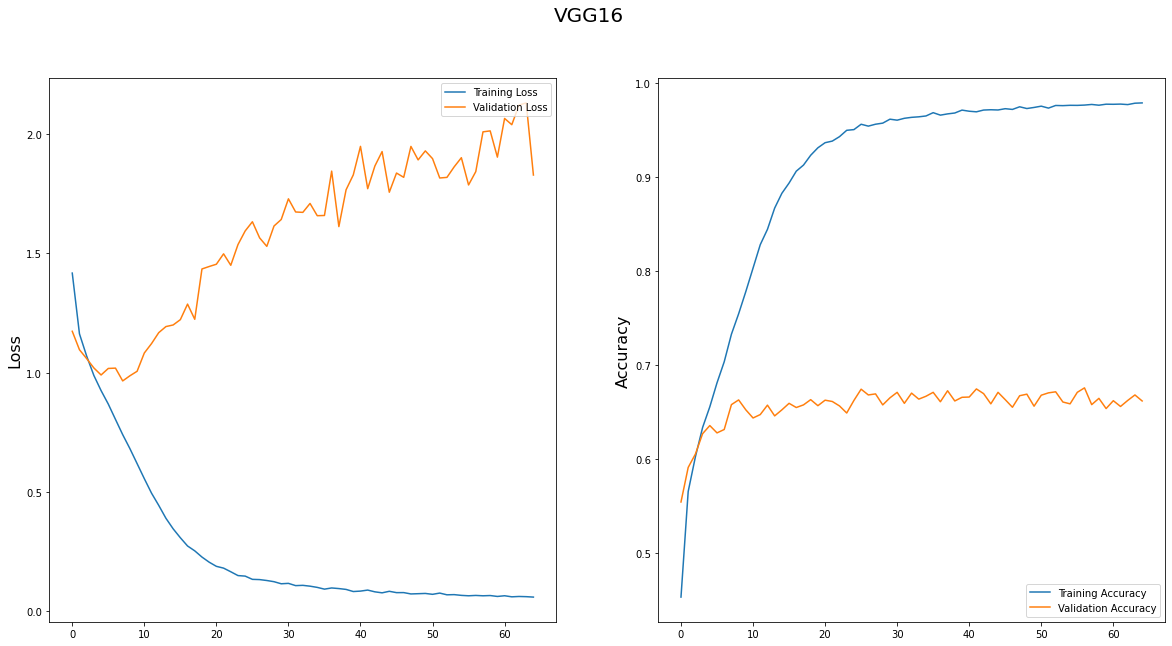

3586/3586 [==============================] - 15s 4ms/step - loss: 1.8288 - accuracy: 0.6615
Test Loss: 1.828806757926941
Test Accuracy: 0.6614612340927124


In [63]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('VGG16', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Evaluate Model
result = model_vgg.evaluate(test_generator_2, steps=step_size_test) 
print("Test Loss: " + str(result[0]))
print("Test Accuracy: " + str(result[1]))

Predictions

In [64]:
predictions = model_vgg.predict_generator(generator=test_generator_2)
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator_2.classes
class_names = test_generator_2.class_indices.keys()

Confusion Matrix

Confusion matrix, without normalization
[[259   8  57  28  44  64   5]
 [  9  37   1   3   2   4   0]
 [ 50   2 258  13  52  97  24]
 [  9   1  26 760  57  24  18]
 [ 37   0  42  51 367 105   5]
 [ 49   8  76  30 121 361   7]
 [ 11   1  36  11  18   8 330]]


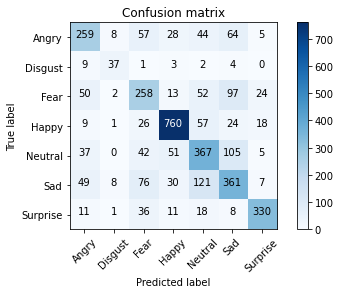

In [65]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

Classification Report

In [66]:
print('Classification Report')
print(classification_report(test_generator_2.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Angry       0.61      0.56      0.58       465
     Disgust       0.65      0.66      0.65        56
        Fear       0.52      0.52      0.52       496
       Happy       0.85      0.85      0.85       895
     Neutral       0.56      0.60      0.58       607
         Sad       0.54      0.55      0.55       652
    Surprise       0.85      0.80      0.82       415

    accuracy                           0.66      3586
   macro avg       0.65      0.65      0.65      3586
weighted avg       0.66      0.66      0.66      3586



In [67]:
accuracy = accuracy_score(test_generator_2.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 66.1% 


Misclassified Images

Pred = Neutral | Label = Angry


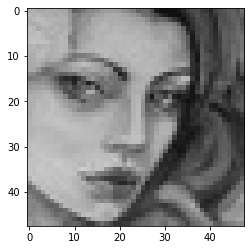

In [68]:
for i, (img, label) in enumerate(test_generator_2): # [B, H, W, C] 
    pred = y_pred[i]    #shuffle should be false
    
    img = img[0] # [H, W, C]
    label = np.argmax(label[0])
    print(f"Pred = {label_to_text[pred]} | Label = {label_to_text[label]}")
    if pred != label:
        plt.imshow(img)
        break

## Model D: ResNet Transfer Learning

Model Build

In [69]:
resnet = ResNet50(include_top=False,
                  input_shape=(48,48,3),
                  weights = "imagenet",
                  pooling='avg',
                  #input_shape=None,
                  classes=num_classes)

"""
option 1
setting all layers trainable
"""

resnet.trainable = True

set_trainable = False
for layer in resnet.layers:
    set_trainable = True

"""
option 2
setting conv5block onwards as trainable
"""
# resnet.trainable = True

# set_trainable = False

# for layer in resnet.layers:
#     layer.trainable = False

# for layer in resnet.layers[143:]:
#     layer.trainable = True        
        
"""
option 3
"""
#ResNet50 neural-net has batch-normalization (BN) layers and using the pre-trained model causes issues with BN layers, if the target dataset on which model is being trained on is different from the originally used training dataset. This is because the BN layer would be using statistics of training data, instead of one used for inference.
#TLDR: Make batch-normalization layers of a pre-trained model as trainable, meaning allowing weight updates to happen during training.

# for layer in resnet.layers:
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


'\noption 3\n'

In [70]:
# adding dense layers
x = resnet.output

# x = GlobalAveragePooling2D()(x) #Adaptive Pooling

# # let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# # and a logits layer -- let's say we have 2 classes
predictions = Dense(num_classes, activation='softmax')(x)

# # this is the model we will train
model_resnet = Model(inputs=resnet.input, outputs=predictions)


# x = Flatten()(vgg.output)
# prediction = Dense(num_classes, activation='softmax')(x)
# model_vgg = Model(inputs=vgg.input, outputs=prediction)
#model_resnet.summary()

# x = Flatten()(resnet.output)
# prediction = Dense(7, activation='softmax')(x)
# model_resnet = Model(inputs=resnet.input, outputs=prediction)
# model_resnet.summary()

In [71]:
pd.set_option('display.max_rows', None)
layers = [(layer, layer.name, layer.trainable) for layer in model_resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])       

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_4,True
1,<tensorflow.python.keras.layers.convolutional....,conv1_pad,True
2,<tensorflow.python.keras.layers.convolutional....,conv1_conv,True
3,<tensorflow.python.keras.layers.normalization_...,conv1_bn,True
4,<tensorflow.python.keras.layers.core.Activatio...,conv1_relu,True
5,<tensorflow.python.keras.layers.convolutional....,pool1_pad,True
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,pool1_pool,True
7,<tensorflow.python.keras.layers.convolutional....,conv2_block1_1_conv,True
8,<tensorflow.python.keras.layers.normalization_...,conv2_block1_1_bn,True
9,<tensorflow.python.keras.layers.core.Activatio...,conv2_block1_1_relu,True


In [72]:
model_resnet.compile(loss='categorical_crossentropy',
                     optimizer=optimizers.Adam(lr),
                     metrics=['accuracy'])

In [73]:
checkpoint_rs = ModelCheckpoint(filepath='model_resnet.h5',
                             verbose=1,
                             save_best_only=True)


callbacks_list_resnet = [checkpoint_rs]

start = datetime.now()

history = model_resnet.fit_generator(train_generator_2,
                                     steps_per_epoch=step_size_train,
                                     epochs = num_epochs, 
                                     verbose=1,
                                     validation_data = test_generator_2, 
                                     validation_steps = step_size_test,
                                     callbacks=callbacks_list_resnet)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/65
446/446 [==============================] - ETA: 0s - loss: 1.6395 - accuracy: 0.3847
Epoch 00001: val_loss improved from inf to 10.28722, saving model to model_resnet.h5
446/446 [==============================] - 98s 220ms/step - loss: 1.6395 - accuracy: 0.3847 - val_loss: 10.2872 - val_accuracy: 0.1804
Epoch 2/65
446/446 [==============================] - ETA: 0s - loss: 1.2674 - accuracy: 0.5206
Epoch 00002: val_loss improved from 10.28722 to 1.50768, saving model to model_resnet.h5
446/446 [==============================] - 104s 234ms/step - loss: 1.2674 - accuracy: 0.5206 - val_loss: 1.5077 - val_accuracy: 0.4398
Epoch 3/65
446/446 [==============================] - ETA: 0s - loss: 1.1221 - accuracy: 0.5806
Epoch 00003: val_loss improved from 1.50768 to 1.32711, saving model to model_resnet.h5
446/446 [==============================] - 102s 228ms/step - loss: 1.1221 - accuracy: 0.5806 - val_loss: 1.3271 - val_accuracy: 0.5226
Epoch 4/65
446/446 [=========================

Evaluating Model Performance

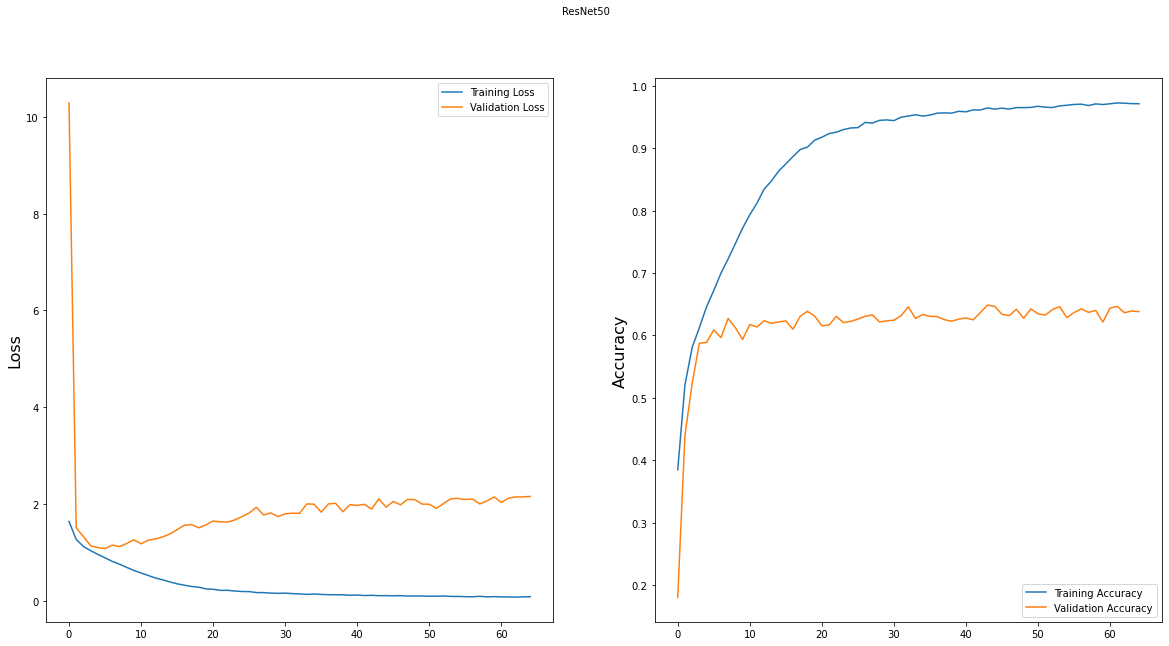

3586/3586 [==============================] - 33s 9ms/step - loss: 2.1561 - accuracy: 0.6380
Test Loss: 2.156071186065674
Test Accuracy: 0.6380367875099182


In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('ResNet50', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Evaluate Model
result = model_resnet.evaluate(test_generator_2, steps=step_size_test) 
print("Test Loss: " + str(result[0]))
print("Test Accuracy: " + str(result[1]))

Predictions

In [75]:
predictions = model_resnet.predict_generator(generator=test_generator_2)
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator_2.classes

Confusion Matrix

Confusion matrix, without normalization
[[246   7  49  41  66  53   3]
 [  8  30   3   4   6   5   0]
 [ 52   1 230  21  64  90  38]
 [ 13   1  20 755  66  24  16]
 [ 28   2  44  57 369 101   6]
 [ 65   2  69  52 120 330  14]
 [ 15   1  28  20  16   7 328]]


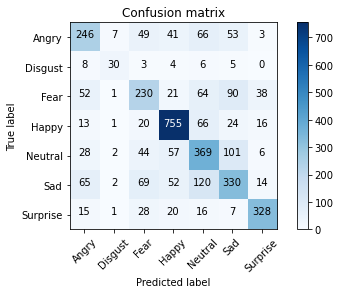

In [76]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

Classification Report

In [77]:
print('Classification Report')
print(classification_report(test_generator_2.classes, y_pred, target_names=target_names))
accuracy = accuracy_score(test_generator_2.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Classification Report
              precision    recall  f1-score   support

       Angry       0.58      0.53      0.55       465
     Disgust       0.68      0.54      0.60        56
        Fear       0.52      0.46      0.49       496
       Happy       0.79      0.84      0.82       895
     Neutral       0.52      0.61      0.56       607
         Sad       0.54      0.51      0.52       652
    Surprise       0.81      0.79      0.80       415

    accuracy                           0.64      3586
   macro avg       0.63      0.61      0.62      3586
weighted avg       0.64      0.64      0.64      3586

Accuracy in test set: 63.8% 


Misclassified Image

Pred = Neutral | Label = Angry


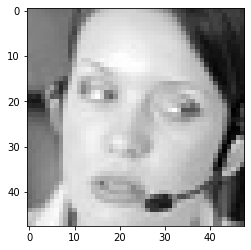

In [78]:
for i, (img, label) in enumerate(test_generator_2): # [B, H, W, C] 
    pred = y_pred[i]    #shuffle should be false
    
    img = img[0] # [H, W, C]
    label = np.argmax(label[0])
    print(f"Pred = {label_to_text[pred]} | Label = {label_to_text[label]}")
    if pred != label:
        plt.imshow(img)
        break